### Spectroscopic Data Analysis
        Sean Keenan, PhD Physics
        Quantum Memories Group, Heriot-Watt University, Edinburgh
        2021

In [1]:
import spec_funcs as sf
import fit_funcs as ff
import class_test as ct

##### Set-up script
        Select input folder and polarisation

In [2]:
# folder containing all the requisite subfolders and data - refrences included
path = r"C:\Users\sk88\Desktop\0222_BB"
# mark energies / wavelengths of interest
woi = [595.24, 604.23, 605.36]
# calibrate wavelength of OSA
calibration = 1.054269
# reference names
refs = "ref", "reference", "R"
# file extension types
exts = (".csv", ".txt", ".CSV")
exceptions = ("notes", "setup", "ignore")

##### Import Raw Spectroscopy Data
        Load raw data from csv file (delimiter is not a problem) and sort into groups - polarisations -> reference / spectrum


In [3]:
folder_list, file_list = sf.dir_interogate(path, exts, exceptions)
path_names = sf.read_files(folder_list, file_list)
ref_names, data_names = sf.search_paths(path_names, refs)
polarisations = sf.find_numbers(ref_names, tail=1)
ref_data, ref_metadata = sf.data_extract(ref_names, polarisations)
data_sets, metadata_sets = sf.data_extract(data_names, polarisations)
wave_sets, OD_sets = sf.OD_calc(ref_data, data_sets, correction=True, c_factor=calibration)
shifted_sets = sf.data_shift(wave_sets, calibration)
labels = 'wavelength (nm)', 'OD'
#sf.plotter(shifted_sets, OD_sets, keys=polarisations, axis_lbls=labels, lims=[560, 620], shifter=1, woi=woi, save=True, data_labels=folder_list)

In [4]:
OD_smoothed = sf.smooth_data(OD_sets, 0.2)
#sf.plotter(shifted_sets, OD_smoothed, keys=polarisations, axis_lbls=labels, lims=[550, 660], shifter=1, woi=woi, save=False, data_labels=folder_list)

c:\Users\sk88\Documents\Python\Spectroscopy\spec_funcs.py:447: RuntimeWarning: divide by zero encountered in divide
  (lambda x: 1e7/x, lambda x: 1e7/x))


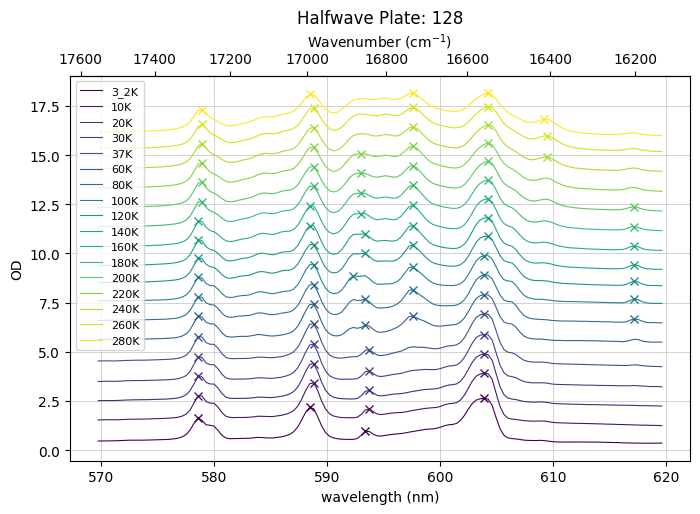

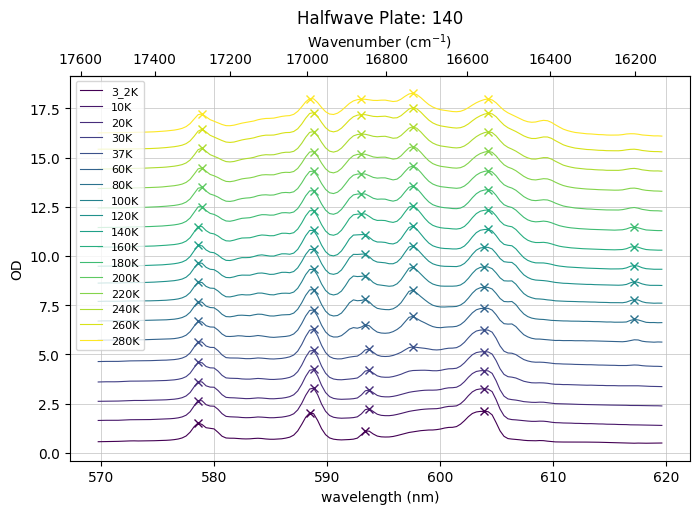

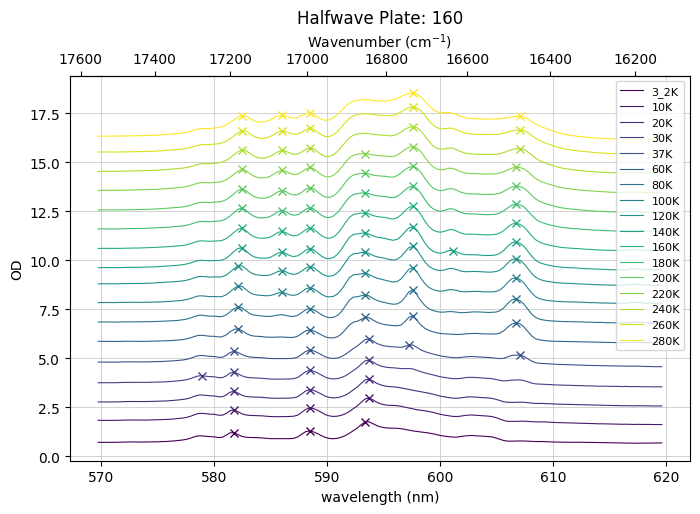

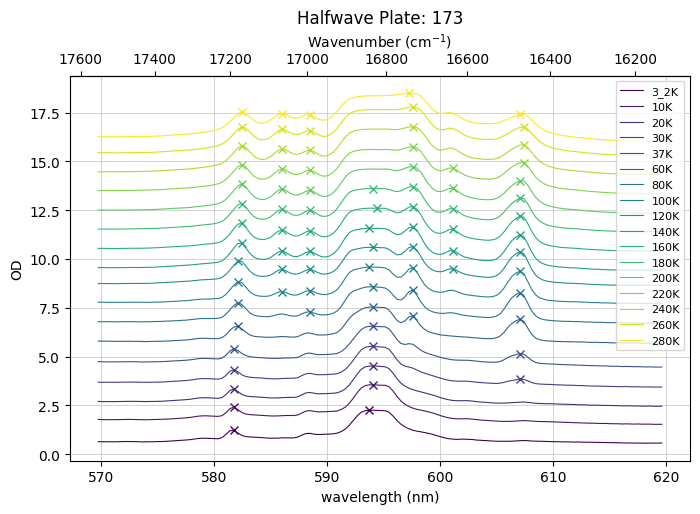

In [5]:
peaks = sf.peak_find(OD_smoothed, tolerance=0.05)
sf.plotter(x_data=wave_sets, y_data=OD_smoothed, data_indexes=peaks, keys=polarisations, axis_lbls=labels, shifter=1, lims=[570, 620], data_labels=folder_list)

In [13]:
frequencies = sf.peak_freq(peaks, wave_sets, lims=[580, 620])

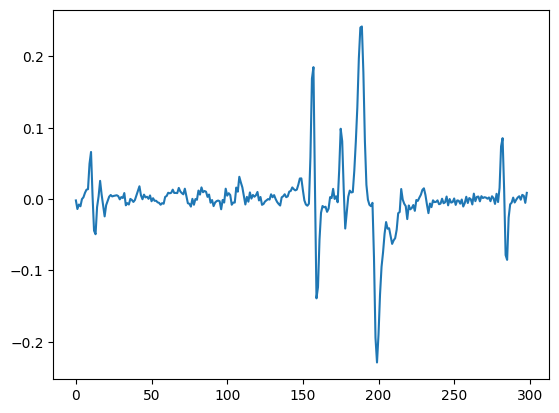

In [8]:
import matplotlib.pyplot as mp
import numpy as np
diff = np.diff(OD_sets[3][0][500:800], n=1)

mp.plot(diff)

In [9]:
x =np.linspace(-100, 100, 10000)
amp_g = 40
amp_l = 20
y_0 = 0
x_0g = 1
x_0l = -1
sigma = 15
gamma = 40
eta = 0.8

gauss = sf.gaussian(x, amp_g, y_0, x_0g, sigma)
lorentz = sf.lorentzian(x, amp_l, y_0, x_0l, gamma)
noise = np.random.normal(size=np.size(gauss))

voigt = sf.pseudo_voigt(x, y_0, amp_g, x_0g, sigma, amp_l, x_0l, gamma, eta) + noise

mp.plot(x, gauss, 'r', label='gauss')
mp.plot(x, lorentz, 'b', label='lorentz')
mp.plot(x, voigt, 'orange', alpha=0.5, label='voigt')
mp.legend()

AttributeError: module 'spec_funcs' has no attribute 'gaussian'

In [ ]:
fit_g = sf.fitgauss(x, voigt)
fit_l = sf.fitlorentz(x, voigt)
fit_v = sf.fitgls(x, voigt)

mp.plot(x, sf.lorentzian(x, *fit_l[0]), '--b', label='lorentz fit')
mp.plot(x, sf.gaussian(x, *fit_g[0]), '--g', label='gauss fit')
mp.plot(x, sf.pseudo_voigt(x, *fit_v[0]), '--r', label='voigt fit')
mp.plot(x, voigt, color='orange', alpha=0.5, label='noisey voigt')
mp.legend()